In [1]:
import pandas as pd
import numpy as np

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV

from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import confusion_matrix, accuracy_score


from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
class FalseScaler:
    def __init__(self):
        pass

    def fit(self, X):
        return X

    def transform(self, X):
        return X

    def fit_transform(self, X):
        return X

    def inverse_transform(self, X):
        return X


In [131]:
all_features = ['PassengerId','Pclass','Name','Sex','Age','SibSp','Parch','Ticket','Fare','Cabin','Embarked']

target_feature = ['Survived']

# train_features = ['Pclass','Sex','Age','Fare']
# train_features = ['Pclass','Sex','Age','Fare','SibSp','Parch','Embarked']


# drop_features = [feat for feat in all_features if feat not in train_features]

# numerical_features = ['Age']
numerical_features = ['Age','Fare', 'SibSp','Parch']

label_features = ['Sex','Cabin']

categorical_features = ['Pclass','Embarked','Ticket']

# categorical_features_no_label = [feat for feat in categorical_features if feat not in label_features]

# print('Drop features: {}\nCategorical: {}\n'.format(drop_features,categorical_features))

In [96]:
raw_dataset = pd.read_csv('train.csv')
dataset = raw_dataset
X = dataset.drop(target_feature, axis=1)
y = dataset[target_feature].values

dataset_test = pd.read_csv('test.csv')
# test_data_raw_raw = dataset_test[dataset_test['Sex']=='male']
test_data_raw = dataset_test
# test_data_raw.loc[test_data_raw['Parch']==9,'Parch'] = np.nan
# test_data_raw.iloc[342]
#

In [97]:
from sklearn.cluster import KMeans

km = KMeans(n_clusters=5)

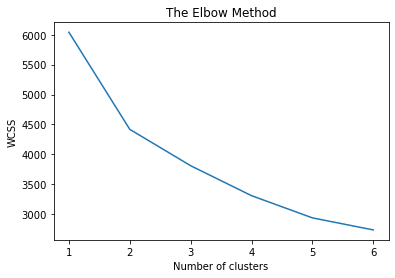

In [98]:
wcss=[]
r=7
for i in range(1, r):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(X_full)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, r), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [99]:
class Cluster:
    def __init__(self, n_clusters=5):
        self.km = KMeans(n_clusters=n_clusters)
    def fit(self,x):
        return self.km.fit(x)
    def transform(self,x):
        # new_x = x.copy()
        return np.concatenate((x,self.km.predict(x).reshape(-1,1)), axis=1)
    def fit_transform(self,x):
        self.fit(x)
        return self.transform(x)

<AxesSubplot:xlabel='Cluster', ylabel='count'>

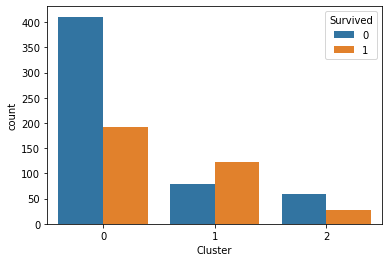

In [100]:
t = dataset.copy()
t['Ticket'] = t['Ticket'].map(lambda x: len(x))
t['Cluster'] = KMeans(n_clusters=3).fit_predict(X_full)
sns.countplot( data=t, x="Cluster", hue='Survived')

In [101]:
data_targets_raw = pd.read_csv('submission_perfect.csv')
# data_targets = data_targets_raw[data_targets_raw['PassengerId'].isin(test_data_raw_raw['PassengerId'])]['Survived'].values.reshape(-1,1)
data_targets = data_targets_raw['Survived'].values.reshape(-1,1)

In [102]:
dataset[dataset.isna()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
886,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
887,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
888,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
889,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [103]:
test_data_raw.dtypes

[pd.api.types.is_integer_dtype(t) for t in test_data_raw.dtypes]

[True, True, False, False, False, True, True, False, False, False, False]

In [104]:
def make_mi_scores(X_s, y):
    X_s = X_s.copy()
    for colname in X_s.select_dtypes(["object", "category"]):
        X_s[colname], _ = X_s[colname].factorize()
    # All discrete features should now have integer dtypes
    # print(X_s.dtypes)
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X_s.dtypes]
    mi_scores = mutual_info_classif(X_s, y, discrete_features=discrete_features, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X_s.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores


def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

In [105]:
Tita().fit_transform(tm)

,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Family Size
0,3,male,22.0,1,0,9,7.2500,Yes,S,2
1,1,female,38.0,1,0,8,71.2833,Yes,C,2
2,3,female,26.0,0,0,11-16,7.9250,Yes,S,1
3,1,female,35.0,1,0,6,53.1000,Yes,S,2
4,3,male,35.0,0,0,6,8.0500,Yes,S,1
...,...,...,...,...,...,...,...,...,...,...
886,2,male,27.0,0,0,6,13.0000,Yes,S,1
887,1,female,19.0,0,0,6,30.0000,Yes,S,1
888,3,female,24.0,1,2,10,23.4500,Yes,S,4
889,1,male,26.0,0,0,6,30.0000,Yes,C,1


C:\Users\Dudeonyx\anaconda3\envs\TensorFlow26\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


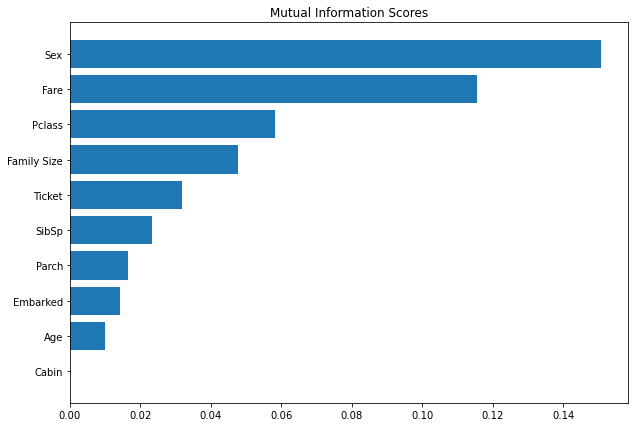

In [106]:
plt.figure(figsize=(10,7))
tm = X.fillna(X.mode().loc[0])
plot_mi_scores(make_mi_scores(Tita().fit_transform(tm),y))
# tm.info()
# X_df.info()
# y

In [134]:
def ticket(x):
    length = len(x)
    if length < 5:
        return '3-5'
    if length < 11:
        return str(length)
    if length < 17:
        return '11-16'
    else:
        return str(length)
class Tita:
    def __init__(self):
        pass
    def fit(self,x,y=None):
        self.embarked = x['Embarked'].mode()[0]
        pass
    def transform(self,x,y=None):
        new_x = x.drop(['Name', 'PassengerId'], axis=1).copy()
        # def fam(x):
        #     if x == 0:
        #         return "None"
        #     if x < 3:
        #         return "small"
        #     if x < 6:
        #         return "medium"
        #     else:
        #         return "large"
        new_x['Parch']=new_x['Parch'].map(lambda x: x if x < 6 else 6)
        # x['SibSp']=x['SibSp'].map(fam)
        # new_x['Family Size'] = new_x['SibSp'] + new_x["Parch"] + 1

        # new_x['S P ratio'] = (new_x['SibSp']/new_x["Parch"]).map(lambda x: x if np.isfinite(x) else 0)
        new_x['Cabin'] = x['Cabin'].map(lambda x: 'Yes' if not pd.isna(x) else 'No')
        # new_x['Ticket'] = x['Ticket'].map(lambda x: 1 if not pd.isna(x) else 0)
        new_x['Embarked'].fillna(self.embarked, inplace=True)
        new_x['Ticket'] = new_x['Ticket'].map(ticket)
        # print(new_x['Embarked'].info())
        # new_x['No. features'] = new_x.apply().sum(axis=1)
        return new_x
    def fit_transform(self, x,y=None):
        self.fit(x)
        return self.transform(x)

In [135]:
tes = Tita()
# tes.transform(dataset).
tes.fit_transform(dataset)

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,3,male,22.0,1,0,9,7.2500,No,S
1,1,1,female,38.0,1,0,8,71.2833,Yes,C
2,1,3,female,26.0,0,0,11-16,7.9250,No,S
3,1,1,female,35.0,1,0,6,53.1000,Yes,S
4,0,3,male,35.0,0,0,6,8.0500,No,S
...,...,...,...,...,...,...,...,...,...,...
886,0,2,male,27.0,0,0,6,13.0000,No,S
887,1,1,female,19.0,0,0,6,30.0000,Yes,S
888,0,3,female,NaN,1,2,10,23.4500,No,S
889,1,1,male,26.0,0,0,6,30.0000,Yes,C


<AxesSubplot:>

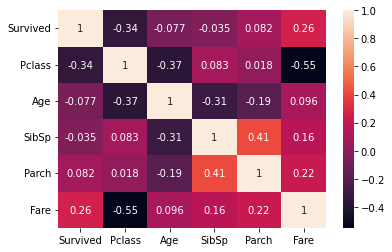

In [136]:
sns.heatmap(tes.fit_transform(dataset).corr(), annot=True)

In [139]:
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.feature_extraction.text import _VectorizerMixin
from sklearn.feature_selection._base import SelectorMixin

num = make_pipeline(IterativeImputer(max_iter=10, random_state=0),StandardScaler())
cat = make_pipeline(SimpleImputer(missing_values=np.nan, strategy='most_frequent'),OneHotEncoder(drop='first',handle_unknown='ignore', sparse=False))

ct_ct = ColumnTransformer([
    ('Numerical', num, numerical_features),
    ('Label', OrdinalEncoder(), label_features), 
    # ('Fill categorical', SimpleImputer(missing_values=np.nan, strategy='most_frequent'), categorical_features),
    ('Categorical', cat, categorical_features),
], remainder='passthrough')

ct = make_pipeline(Tita(),ct_ct,)

ct_full_ct = ColumnTransformer([
    ('Numerical', num, numerical_features),
    ('Label', OrdinalEncoder(), label_features), 
    # ('Fill categorical', SimpleImputer(missing_values=np.nan, strategy='most_frequent'), categorical_features),
    ('Categorical', cat, categorical_features),
], remainder='passthrough')
ct_full = make_pipeline(Tita(),ct_full_ct)



# print(X_ct)


In [140]:

def get_feature_out(estimator, feature_in):
    if hasattr(estimator,'get_feature_names'):
        if isinstance(estimator, _VectorizerMixin):
            # handling all vectorizers
            return [f'vec_{f}' \
                for f in estimator.get_feature_names_out()]
        else:
            return estimator.get_feature_names_out(feature_in)
    elif isinstance(estimator, SelectorMixin):
        return np.array(feature_in)[estimator.get_support()]
    else:
        return feature_in


def get_ct_feature_names(ct):
    # handles all estimators, pipelines inside ColumnTransfomer
    # doesn't work when remainder =='passthrough'
    # which requires the input column names.
    output_features = []

    for name, estimator, features in ct.transformers_:
        if name!='remainder':
            if isinstance(estimator, Pipeline):
                current_features = features
                for step in estimator:
                    current_features = get_feature_out(step, current_features)
                features_out = current_features
            else:
                features_out = get_feature_out(estimator, features)
            output_features.extend(features_out)
        elif estimator=='passthrough':
            output_features.extend(ct.feature_names_in_[features])
                
    return output_features

<AxesSubplot:>

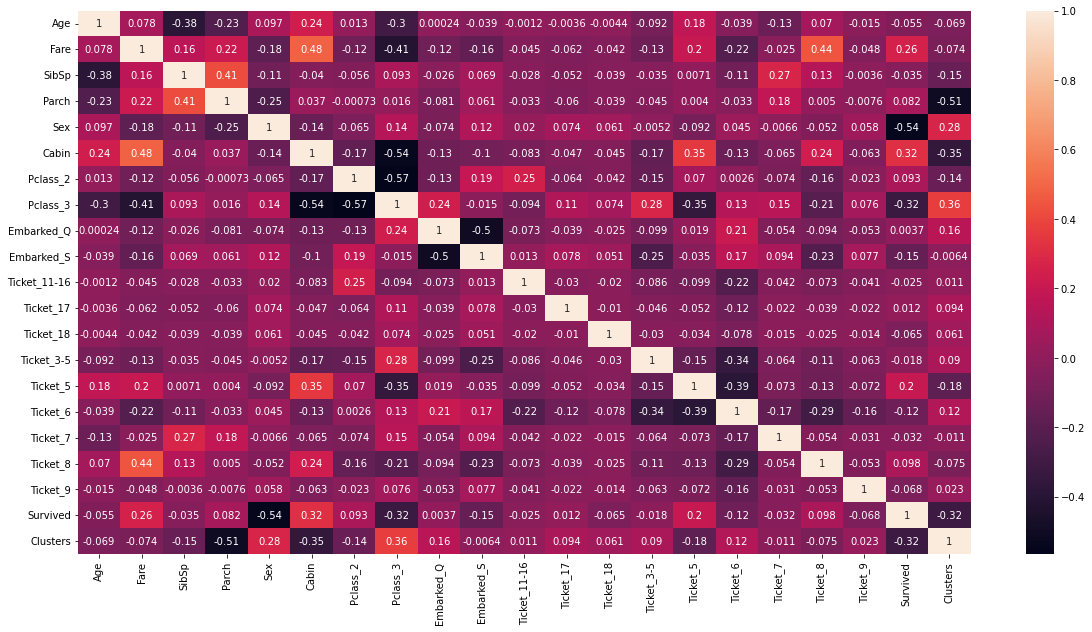

In [141]:
plt.figure(figsize=(20,10))
X_df = pd.DataFrame(Cluster().fit_transform(ct.fit_transform(dataset)), 
             columns=get_ct_feature_names(ct[1])+['Clusters'])
sns.heatmap(X_df.corr(),annot=True)

In [43]:
# pd.DataFrame(test_data, 
#              columns=get_ct_feature_names(ct)).info()

In [142]:


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)

X_full = ct_full.fit_transform(X)
X_train = ct.fit_transform(X_train)

X_test2, X_val, y_test2, y_val = train_test_split(X_test,y_test,test_size=0.5, random_state=0)

X_test = ct.transform(X_test)
X_test2 = ct.transform(X_test2)
X_val = ct.transform(X_val)

In [143]:
cluster = Cluster()
X_full2 = cluster.fit_transform(X_full)

In [144]:
X_full[1]

array([ 0.62330783,  0.78684529,  0.43279337, -0.47367361,  0.        ,
        1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  1.        ,  0.        ])

In [145]:
X_full2[1]

array([ 0.62330783,  0.78684529,  0.43279337, -0.47367361,  0.        ,
        1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  1.        ,  0.        ,  3.        ])

In [146]:
# X_ct = ct.fit_transform(X)

test_data = ct.transform(test_data_raw)
test_data2 = ct_full.transform(test_data_raw)
test_data3 = cluster.transform(test_data2)

In [147]:
from sklearn.tree import DecisionTreeClassifier
dec_classifier = DecisionTreeClassifier(random_state = 0)

# Making the Confusion Matrix
scores = cross_val_score(dec_classifier, X_full, y)
print("Average accuracy: {:0.2f}%".format(scores.mean()*100))
dec_classifier.fit(X_full,y)

Average accuracy: 78.46%


DecisionTreeClassifier(random_state=0)

In [148]:
from sklearn.ensemble import RandomForestClassifier
rf_classifier = RandomForestClassifier(n_estimators = 500,random_state=0, max_depth=10)
rf_classifier.fit(X_train, y_train)

# Making the Confusion Matrix
scores = cross_val_score(rf_classifier, X_full, y.ravel())
print("Average accuracy: {:0.2f}%".format(scores.mean()*100))

# parameters = [
#               {
#                   "n_estimators": list(range(100,801,100)),
#                   "criterion": ["gini", "entropy", "log_loss"],
#                   "max_depth":list(range(2,6,1)),

#               }
#               ]
# rf_grid = GridSearchCV(estimator = rf_classifier,
#                            param_grid = parameters,
#                            scoring = 'accuracy',
#                            cv = 5,
#                            n_jobs = -1)
# rf_grid.fit(X_full, y.ravel())
# best_accuracy = rf_grid.best_score_
# best_parameters = rf_grid.best_params_
# print("Best Accuracy: {:.2f} %".format(best_accuracy*100))
# print("Best Parameters:", best_parameters)
# rf_classifier.fit(X_full,y)

C:\Users\Dudeonyx\AppData\Local\Temp\ipykernel_17692\4158495473.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_classifier.fit(X_train, y_train)


Average accuracy: 82.27%


In [146]:
# Training the K-NN model on the Training set
from sklearn.neighbors import KNeighborsClassifier
kn_classifier = KNeighborsClassifier(n_neighbors = 21, metric = 'minkowski', p = 2)

parameters = [
              {
                  "n_neighbors": list(range(1,51,1)),
                  
                  "p":list(range(1,6,1)),

              }
              ]
kn_grid = GridSearchCV(estimator = kn_classifier,
                           param_grid = parameters,
                           scoring = 'accuracy',
                           cv = 5,
                           n_jobs = -1)
kn_grid.fit(X_full, y)
best_accuracy = kn_grid.best_score_
best_parameters = kn_grid.best_params_
print("Best Accuracy: {:.2f} %".format(best_accuracy*100))
print("Best Parameters:", best_parameters)
# kn_classifier.fit(X_full,y.ravel())

Best Accuracy: 80.48 %
Best Parameters: {'n_neighbors': 13, 'p': 4}


C:\Users\Dudeonyx\anaconda3\envs\TensorFlow26\lib\site-packages\sklearn\neighbors\_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


In [215]:
np.array([0.25224566]).round(2)

array([0.25])

In [149]:
from sklearn.svm import SVC
svc_classifier = SVC(kernel = 'rbf')
# svc_classifier.fit(X_train, y_train)
svc_classifier2 = SVC(kernel = 'rbf')
score = cross_val_score(svc_classifier2, X_full2, y.ravel()).mean()
print("Accuracy: {:.2f}%".format(score*100))
parameters = [
              {'C': list(np.arange(0.05,1.55,0.05).round(2)), 'kernel': ['rbf'], 'gamma': list(np.arange(0.05,1.05,0.05).round(2))}]
svc_grid = GridSearchCV(estimator = svc_classifier2,
                           param_grid = parameters,
                           scoring = 'accuracy',
                           cv = 5,
                           n_jobs = -1)
svc_grid.fit(X_full2, y.ravel())
best_accuracy = svc_grid.best_score_
best_parameters = svc_grid.best_params_
print("Best Accuracy: {:.2f} %".format(best_accuracy*100))
print("Best Parameters:", best_parameters)

Accuracy: 82.38%
Best Accuracy: 83.50 %
Best Parameters: {'C': 1.5, 'gamma': 0.15, 'kernel': 'rbf'}


In [81]:
best_parameters = svc_grid.best_params_
print("Best Accuracy: {:.2f} %".format(best_accuracy*100))
print("Best Parameters:", best_parameters)

Best Accuracy: 82.94 %
Best Parameters: {'C': 1.45, 'gamma': 0.2, 'kernel': 'rbf'}


In [148]:
y_pred = svc_grid.predict(test_data2)
cm = confusion_matrix(data_targets, y_pred)
print(cm)
accuracy_score(data_targets, y_pred)

[[211  49]
 [ 47 111]]


0.7703349282296651

In [269]:
from sklearn.svm import SVC
svc_l_classifier = SVC(kernel = 'linear')
svc_l_classifier.fit(X_train, y_train)

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix, accuracy_score
y_pred = svc_l_classifier.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print(cm)
accuracy_score(y_test, y_pred)

[[97 13]
 [22 47]]


C:\Users\Dudeonyx\anaconda3\envs\TensorFlow26\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.8044692737430168

In [56]:
import tensorflow as tf
output_size = 2

batch_size = 100

input_size = 9

max_epochs = 200

hidden_layer_size = 1500

model = tf.keras.Sequential([
    # tf.keras.layers.Dense(input_size,activation='relu'),
    # tf.keras.layers.Dense(input_size,activation='sigmoid'),
    # tf.keras.layers.Dense(hidden_layer_size,activation='relu'),
    tf.keras.layers.Dense(hidden_layer_size,activation='relu'),
    # tf.keras.layers.Dense(hidden_layer_size,activation='sigmoid'),
    tf.keras.layers.Dense(hidden_layer_size,activation='relu'),
    tf.keras.layers.Dense(hidden_layer_size,activation='relu'),
    # tf.keras.layers.Dense(hidden_layer_size,activation='relu'),
    # tf.keras.layers.Dense(hidden_layer_size,activation='relu'),
    # tf.keras.layers.Dense(hidden_layer_size,activation='relu'),
    tf.keras.layers.Dense(hidden_layer_size,activation='relu'),
    # tf.keras.layers.Dense(hidden_layer_size,activation='sigmoid'),
    tf.keras.layers.Dense(hidden_layer_size,activation='relu'),
    # tf.keras.layers.Dense(2,activation='relu'),
    tf.keras.layers.Dense(2,activation='softmax'),
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
early_stopper = tf.keras.callbacks.EarlyStopping(patience=5)

# model.fit(
#     X_full,
#     y,
#     epochs=10,
#     # batch_size=batch_size,
#     )
model.fit(
    X_full, y.ravel(),
    epochs=max_epochs,
    # batch_size=batch_size,
    validation_data=(test_data2,data_targets),
    verbose=2,
    callbacks=[early_stopper]
    )

Epoch 1/200
28/28 - 5s - loss: 0.5667 - accuracy: 0.7666 - val_loss: 0.5184 - val_accuracy: 0.7679
Epoch 2/200
28/28 - 2s - loss: 0.4288 - accuracy: 0.8159 - val_loss: 0.5625 - val_accuracy: 0.7703
Epoch 3/200
28/28 - 3s - loss: 0.4040 - accuracy: 0.8373 - val_loss: 0.4941 - val_accuracy: 0.7679
Epoch 4/200
28/28 - 2s - loss: 0.3884 - accuracy: 0.8406 - val_loss: 0.5276 - val_accuracy: 0.7608
Epoch 5/200
28/28 - 2s - loss: 0.3717 - accuracy: 0.8552 - val_loss: 0.6257 - val_accuracy: 0.7679
Epoch 6/200
28/28 - 2s - loss: 0.3499 - accuracy: 0.8474 - val_loss: 0.6033 - val_accuracy: 0.7584
Epoch 7/200
28/28 - 2s - loss: 0.3449 - accuracy: 0.8485 - val_loss: 0.5218 - val_accuracy: 0.7584
Epoch 8/200
28/28 - 2s - loss: 0.3440 - accuracy: 0.8530 - val_loss: 0.5234 - val_accuracy: 0.7679


In [407]:
test_loss, test_accuracy = model.evaluate(test_data2,data_targets)
# test_loss, test_accuracy = model.evaluate(data['X_test_scaled'],data['y_test_scaled'])

print(f'Test loss: {"%.4f"% test_loss}, Accuracy: {"%.2f" % (test_accuracy *100)}%')

14/14 [==============================] - 3s 180ms/step - loss: 0.5669 - accuracy: 0.7799
Test loss: 0.5669, Accuracy: 77.99%


In [ ]:
y_tf_pred_raw = model.predict(test_data2)
# y_tf_pred_raw = data['y_scaler'].inverse_transform(model.predict(data['X_tf_test']))
y_tf_pred = np.array([ [np.argmax(x)] for x in y_tf_pred_raw])
y_tf_pred


In [186]:
y_tf_pred_raw.shape

(418, 2)

In [45]:
# sv = SVC(C= 1.45, gamma=0.18, kernel= 'rbf') # best so far
# sv = SVC(C= 0.71, gamma=0.23, kernel= 'rbf')
sv = SVC(C= 0.71, gamma=0.23, kernel= 'rbf')
sv.fit(X_full,y.ravel())
accuracy_score(data_targets,sv.predict(test_data2))

0.7679425837320574

In [153]:
def tester(cs,gs):
    results=[]
    for c in cs:
        # %%time
        for g in gs:
            sv = SVC(C=c, gamma=g, kernel= 'rbf')
            sv.fit(X_full,y.ravel())
            acc = accuracy_score(data_targets,sv.predict(test_data2))
            results.append({'accuracy': "{:.2f}%".format(acc*100), 'C': c, 'gamma': g })
    return results

accuracies=tester(list(np.arange(0.05,1.75,0.05).round(3)), list(np.arange(0.025,1.025,0.025).round(3)))
        



In [154]:
accuracies.sort(key=lambda x: x['accuracy'], reverse=True)
# results

In [155]:
accuracies[:10]

[{'accuracy': '78.47%', 'C': 1.15, 'gamma': 0.05},
 {'accuracy': '78.47%', 'C': 1.2, 'gamma': 0.05},
 {'accuracy': '78.47%', 'C': 1.2, 'gamma': 0.1},
 {'accuracy': '78.47%', 'C': 1.25, 'gamma': 0.05},
 {'accuracy': '78.47%', 'C': 1.25, 'gamma': 0.1},
 {'accuracy': '78.47%', 'C': 1.3, 'gamma': 0.05},
 {'accuracy': '78.47%', 'C': 1.3, 'gamma': 0.1},
 {'accuracy': '78.47%', 'C': 1.35, 'gamma': 0.05},
 {'accuracy': '78.47%', 'C': 1.4, 'gamma': 0.05},
 {'accuracy': '78.47%', 'C': 1.45, 'gamma': 0.05}]

In [386]:

y_tf_pred_raw = model.predict(test_data)
# y_tf_pred_raw = data['y_scaler'].inverse_transform(model.predict(data['X_tf_test']))
y_tf_pred = np.array([ [np.argmax(x)] for x in y_tf_pred_raw])

results = pd.DataFrame({
    "DecisionTree": [accuracy_score(data_targets,dec_classifier.predict(test_data2))],
    # "RandomForest": [accuracy_score(data_targets,rf_grid.predict(test_data2))],
    "RandomForest": [accuracy_score(data_targets,rf_classifier.predict(test_data2))],
    "KNeigbors": [accuracy_score(data_targets,kn_grid.predict(test_data2))],
    "SVC -rbf": [accuracy_score(data_targets,svc_grid.predict(test_data2))],
    # "SVC - linear": [accuracy_score(data_targets,svc_l_classifier.predict(test_data))],
    "TensorFlow": [accuracy_score(data_targets,y_tf_pred)],
})

results

ValueError: in user code:

    C:\Users\Dudeonyx\anaconda3\envs\TensorFlow26\lib\site-packages\keras\engine\training.py:1586 predict_function  *
        return step_function(self, iterator)
    C:\Users\Dudeonyx\anaconda3\envs\TensorFlow26\lib\site-packages\keras\engine\training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\Dudeonyx\anaconda3\envs\TensorFlow26\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\Dudeonyx\anaconda3\envs\TensorFlow26\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\Dudeonyx\anaconda3\envs\TensorFlow26\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\Dudeonyx\anaconda3\envs\TensorFlow26\lib\site-packages\keras\engine\training.py:1569 run_step  **
        outputs = model.predict_step(data)
    C:\Users\Dudeonyx\anaconda3\envs\TensorFlow26\lib\site-packages\keras\engine\training.py:1537 predict_step
        return self(x, training=False)
    C:\Users\Dudeonyx\anaconda3\envs\TensorFlow26\lib\site-packages\keras\engine\base_layer.py:1020 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    C:\Users\Dudeonyx\anaconda3\envs\TensorFlow26\lib\site-packages\keras\engine\input_spec.py:250 assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer sequential_14 is incompatible with the layer: expected axis -1 of input shape to have value 24 but received input with shape (None, 20)


In [ ]:
# output = pd.DataFrame({'PassengerId': dataset_test['PassengerId'], 'Survived': y_tf_pred.ravel()})
# output.to_csv('submission.csv', index=False)